In this notebook:
 - distance calculation using Gaia parallax (wrong radial query)
 - distances calculated using RGB cmd cut (wrong radial query)

In [1]:
import pylab as plt
import numpy as np
from astropy.io import fits
import matplotlib as mpl
import math
import astropy.io.fits as fits
from astropy.table import Table 

In [3]:
df = fits.getdata('LMC_EDR3.fits')

In [4]:
fin = np.where(np.isfinite(df['phot_g_mean_mag']) & np.isfinite(df['bp_rp']) & np.isfinite(df['pmra']) & np.isfinite(df['pmdec']) & np.isfinite(df['parallax']))
df = df[fin]


In [5]:
def roi_cut(xcut,ycut,x,y): 
    from matplotlib.path import Path
    tupVerts = list(zip(xcut,ycut))
    points = np.vstack((x,y)).T
    p = Path(tupVerts) # make a polygon
    inside = p.contains_points(points)
    ind, = np.where(~inside)
    cutind, = np.where(inside)
    return ind, cutind
    print (ind, cutind)

In [18]:
r = np.sqrt((ra1 - df['ra'])**2 + (dec1 - df['dec'])**2)

In [28]:
## What is the best radius value? Best step size in ra and dec?
res = np.where(r <= 0.5)

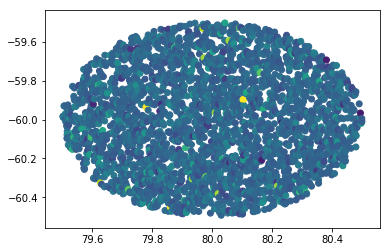

In [29]:
plt.scatter(df['ra'][res], df['dec'][res], c=df['parallax'][res], vmin=0, vmax=0.4)
plt.colorbar()

In [39]:
## RGB cmd cut

def LMCParallax(df, ra, dec, radius=0.3):
    r = np.sqrt((ra - df['ra'])**2 + (dec - df['dec'])**2)
    res = np.where(r <= radius)
    df = df[res]
    xcut = [0.738710, 1.077419, 1.512903, 1.68, 2.035484, 2.4, 2.432258, 1.929032, 1.764516, 1.45, 0.7]
    ycut = [19.346753, 19.9, 19.441558, 18, 16.5, 16.1, 15.85, 15.487013, 15.603896, 16, 18.75]
    x = df['bp_rp']
    y = df['phot_g_mean_mag']
    (ind, cutind) = roi_cut(xcut,ycut,x,y)
    df = df[cutind]
    medpmra = np.nanmedian(df['pmra'])
    medpmdec = np.nanmedian(df['pmdec'])
    pndist = np.sqrt((df['pmra']-medpmra)**2 + (df['pmdec']-medpmdec)**2)
    good = (abs(df['parallax']) < 3*df['parallax_error']) & (pndist<=2.0)
    medplx = np.nanmedian(df['parallax'][good]) 
    ngood = np.sum(good)
    sigma= (1/ngood)*np.sqrt(np.nansum((df['parallax_error'][good])**2)) #standard error of parallax
    return (ngood, medplx, sigma)


In [67]:
dtype = np.dtype([('ra',float),('dec',float),('ngood',int),('parallax',float),('sigma',float)])
cat = np.zeros([9,9],dtype=dtype)
for i in range (9):
    ra = (i/2) + 75
    for j in range (9):
        dec = (j/2) - 75
        (ngood, medplx, sigma) = LMCParallax(df, ra, dec, 0.3) 
        cat[i,j]['ra']=ra
        cat[i,j]['dec']=dec
        cat[i,j]['ngood']=ngood
        cat[i,j]['parallax']=medplx
        cat[i,j]['sigma']=sigma

acat = Table(cat)

In [68]:
acat['parallax'] = acat['parallax'] + 0.02
acat['dist'] = 1/acat['parallax']

Text(0.5,1,'Distance from Gaia Parallax (no offset) [kpc]')

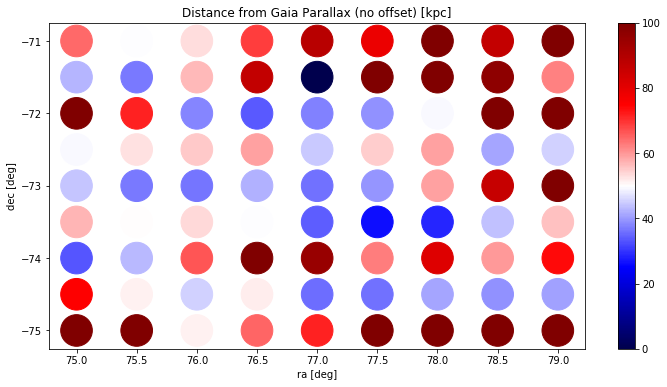

In [73]:
plt.figure(figsize=(12,6))
plt.scatter(acat['ra'], acat['dec'], c=1/acat['parallax'], s=1000, vmin=0, vmax=100, cmap=plt.cm.seismic)
plt.colorbar()
#plt.xlim([110,55])
#plt.ylim([-80,-55])
plt.xlabel('ra [deg]')
plt.ylabel('dec [deg]')
plt.title('Distance from Gaia Parallax (0.02 mas offset) [kpc]')

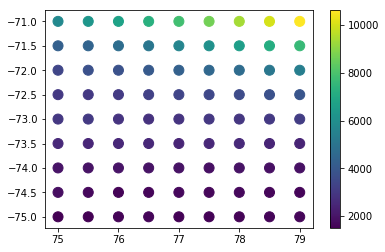

In [75]:
plt.scatter(acat['ra'], acat['dec'], s=100, c=acat['ngood'])
plt.colorbar()

In [81]:
dtype = np.dtype([('ra',float),('dec',float),('ngood',int),('parallax',float),('sigma',float)])
cat = np.zeros([111,51],dtype=dtype)
for i in range (111):
    ra = (i/2) + 55
    for j in range (51):
        dec = (j/2) - 80
        (ngood, medplx, sigma) = LMCParallax(df,ra,dec) 
        cat[i,j]['ra']=ra
        cat[i,j]['dec']=dec
        cat[i,j]['ngood']=ngood
        cat[i,j]['parallax']=medplx
        cat[i,j]['sigma']=sigma
        
acat = Table(cat)
acat.write('LMC_EDR3_dist1.fits', format='fits')

In [82]:
acat['parallax'] = acat['parallax'] + 0.02
acat['dist'] = 1/acat['parallax']

Text(0.5,1,'Distance from Gaia Parallax (0.02 mas offset) [kpc]')

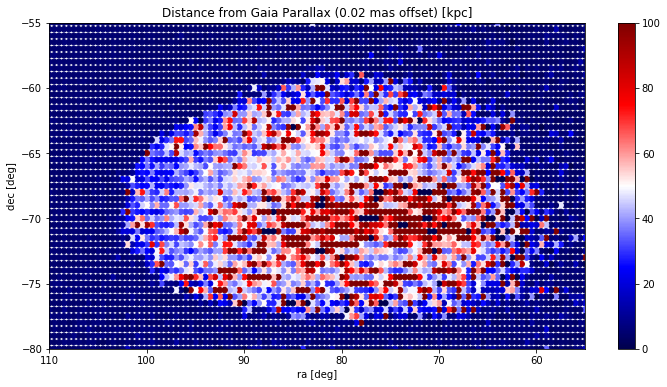

In [87]:
plt.figure(figsize=(12,6))
plt.scatter(acat['ra'], acat['dec'], c=1/acat['parallax'], s=30, vmin=0, vmax=100, cmap=plt.cm.seismic)
plt.colorbar()
plt.xlim([110,55])
plt.ylim([-80,-55])
plt.xlabel('ra [deg]')
plt.ylabel('dec [deg]')
plt.title('Distance from Gaia Parallax (0.02 mas offset) [kpc]')